<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-01-17 18:10:57--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2020-01-17 18:10:58 (14.8 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

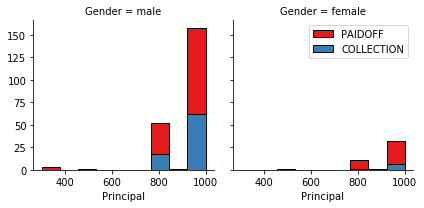

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

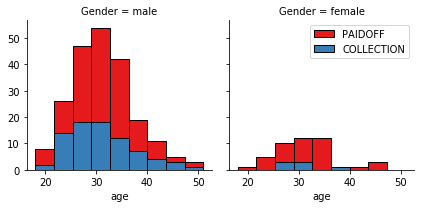

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

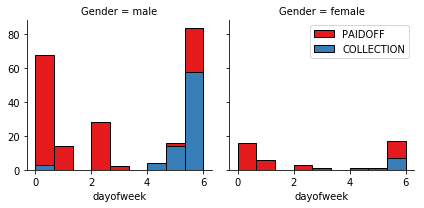

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
# dummy1 = preprocessing.StandardScaler().fit(X).transform(X)
# dummy2 = preprocessing.StandardScaler().fit_transform(X)
# new_dim = dummy1.shape[0] * dummy1.shape[1]
# dummy1 = dummy1.reshape(1, new_dim)
# dummy2 = dummy2.reshape(1, new_dim)
# assert((dummy1 == dummy2).sum() == new_dim)


In [20]:
X_scaled = preprocessing.StandardScaler().fit(X).transform(X)
X_scaled[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

In [21]:
from sklearn.model_selection import train_test_split


# split train_loan.csv into train and test to find the best k
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=1)
  
print(X_train.shape)
print(X_test.shape)

(231, 8)
(115, 8)


# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
# test with different n_neighbors values to find the best
K = 50 # maximum number of neighbors to test
acc = np.zeros((K, 1))  # to hold the accuracies per k
for k in range(1, K+1):
    knn = KNeighborsClassifier(n_neighbors=k)  # build the classifier
    knn.fit(X_train, y_train)  # fit on training data
    preds = knn.predict(X_test)  # test the classifier on the test data
    acc[k-1, 0] = sum(preds==y_test) / max(preds.shape)  # get the accuracy

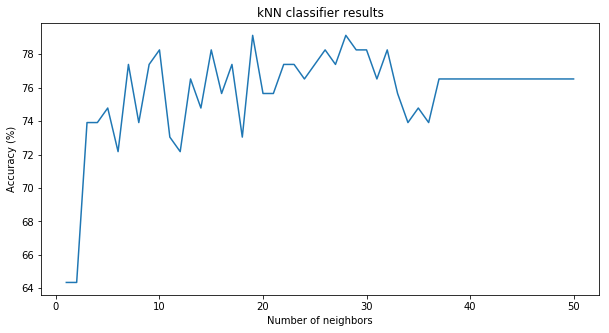

Max accuracy=79.13%, obtained with k=18.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=18, p=2,
           weights='uniform')

In [24]:
def plot_results(acc, x, plt_strings) -> None:
    """Plots acc vs x.
    
    Arguments:
        acc: numpy.ndarray[np.float64], Accuracy values to plot
        
        x: numpy.ndarray[np.float64], x-axis values to plot
        
        plt_strings: Tuple[str, str, str], x-label, y-label and title strings
    """
    plt.figure(figsize=(10, 5))
    plt.plot(x, acc)
    plt.xlabel(plt_strings[0])
    plt.ylabel(plt_strings[1])
    plt.title(plt_strings[2])
    plt.show()


# plot the accuracy vs number of neighbors
x = np.linspace(1, K, K)
plt_strings = ('Number of neighbors', 'Accuracy (%)', 'kNN classifier results')
plot_results(acc*100, x, plt_strings)

# Choose the best k and train the final model on the whole training data
best_k = np.argmax(acc)
best_knn = KNeighborsClassifier(n_neighbors=np.argmax(acc))
best_knn.fit(X_scaled, y)
print(f"Max accuracy={np.max(acc)*100:.2f}%, obtained with k={best_k}.")
best_knn

# Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [26]:
K = 50
acc = np.zeros((K, 1))
for k in range(1, K+1):
    dectree = DecisionTreeClassifier(criterion="entropy", max_depth = k, random_state=0)  # build the classifier
    dectree.fit(X_train, y_train)  # train it
    preds = dectree.predict(X_test)
    acc[k-1, 0] = sum(preds==y_test) / np.max(y_test.shape)  # get the accuracy


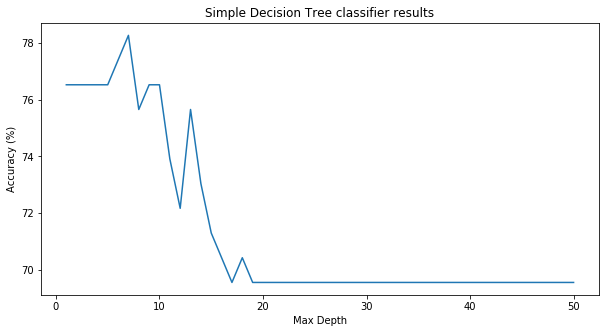

Max accuracy=78.26%, obtained with max_depth=6.


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [27]:
# plot
x = np.linspace(1, K, K)
plt_strings = ('Max Depth', 'Accuracy (%)', 'Simple Decision Tree classifier results')
plot_results(acc*100, x, plt_strings)

# Choose the best max_depth and train the final model on the whole training data
best_max_depth = np.argmax(acc)
best_dectree = DecisionTreeClassifier(criterion="entropy", max_depth = best_max_depth, random_state=0)
best_dectree.fit(X_scaled, y)
print(f"Max accuracy={np.max(acc)*100:.2f}%, obtained with max_depth={best_max_depth}.")
best_dectree

# Support Vector Machine

In [28]:
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate, train_test_split, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

In [29]:
# NOTE: It takes some time to run this code cell

n_folds = 5
gamma_values = [10, 1, 1e-1]
C_values = [1]#np.concatenate((np.arange(1,10), [100, 1000]))
degree_values = [2, 3]  #[2, 3, 4, 5]

# since we are going to use pipeline put clf__ (name of SVC model + double underscore) in front of the SVC prameters
p_grid = [{'clf__kernel': ['linear'],  'clf__C': C_values},
          {'clf__kernel': ['rbf'],     'clf__C': C_values, 'clf__gamma': gamma_values},
          {'clf__kernel': ['poly'],    'clf__C': C_values, 'clf__gamma': gamma_values, 'clf__degree': degree_values},
          {'clf__kernel': ['sigmoid'], 'clf__C': C_values, 'clf__gamma': gamma_values}]

# use cross validation with 5 folds to tune the SVM hyperparameters
cv_groups = KFold(n_splits=n_folds, shuffle=True, random_state=1)

# Pipeline: first do feature scaling and then train the SVC classifier using the hyperparameter values in p_grid
pipe = Pipeline([('scaler', preprocessing.StandardScaler()), ('clf', SVC())])

# use accuracy and F1 as performance metrics
scoring_types = {'Accuracy': make_scorer(accuracy_score), 'F1': 'f1_micro'}

# perform a search on the grid constructed by the values in p_grid and using the pipeline as the estimator
GSCV = GridSearchCV(estimator=pipe, param_grid=p_grid, cv=cv_groups, scoring=scoring_types, refit='F1', return_train_score=True)
GSCV.fit(X, y)  # caution: not using the scaled features as it would be done separately for each set of folds

all_results_df = pd.DataFrame(GSCV.cv_results_)
# summary_df = all_results_df[['param_clf__C', 'param_clf__kernel', 'param_clf__gamma', 'param_clf__degree',
#                              'split0_test_F1', 'split1_test_F1', 'split2_test_F1', 'split3_test_F1', 'split4_test_F1',
#                              'mean_test_F1', 'std_test_F1', 'rank_test_F1',
#                              'split0_test_Accuracy', 'split1_test_Accuracy', 'split2_test_Accuracy', 'split3_test_Accuracy', 'split4_test_Accuracy',
#                              'mean_test_Accuracy', 'std_test_Accuracy', 'rank_test_Accuracy']].copy()

all_results_df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data wit

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__kernel,param_clf__gamma,param_clf__degree,params,split0_test_Accuracy,...,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1
0,0.005423,0.000755,0.003592,0.000276,1,linear,NaN,NaN,"{'clf__C': 1, 'clf__kernel': 'linear'}",0.742857,...,0.748555,0.045279,2,0.753623,0.736462,0.768953,0.743682,0.758123,0.752169,0.011296
1,0.008769,0.000965,0.004650,0.000121,1,rbf,10,NaN,"{'clf__C': 1, 'clf__gamma': 10, 'clf__kernel':...",0.728571,...,0.728324,0.077326,6,0.869565,0.851986,0.888087,0.862816,0.873646,0.869220,0.011947
2,0.007859,0.000301,0.004417,0.000043,1,rbf,1,NaN,"{'clf__C': 1, 'clf__gamma': 1, 'clf__kernel': ...",0.757143,...,0.731214,0.062772,5,0.815217,0.815884,0.866426,0.794224,0.830325,0.824415,0.023953
3,0.006659,0.000204,0.004048,0.000062,1,rbf,0.1,NaN,"{'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel'...",0.742857,...,0.748555,0.040390,2,0.760870,0.754513,0.776173,0.743682,0.768953,0.760838,0.011273
4,3.820372,3.069765,0.004528,0.000155,1,poly,10,2,"{'clf__C': 1, 'clf__degree': 2, 'clf__gamma': ...",0.742857,...,0.728324,0.041582,6,0.804348,0.776173,0.801444,0.765343,0.790614,0.787584,0.014881


In [30]:
# get the params of the model with the highest accuracy
best_params_index = all_results_df[['mean_test_Accuracy']].copy().values.argmax(axis=0)
best_params = all_results_df.loc[best_params_index]['params'].copy().values[0]

best_gamma = 'auto'  # default value
best_degree = 3  # default value
for key in best_params:
    if key=='clf__C':
        best_C = best_params['clf__C']
    if key=='clf__kernel':
        best_kernel = best_params['clf__kernel']
    if key=='clf__gamma':
        best_gamma = best_params['clf__gamma']
    if key=='clf__degree':
        best_degree = best_params['clf__degree']
        
print(best_params_index, best_params)

[6] {'clf__C': 1, 'clf__degree': 2, 'clf__gamma': 0.1, 'clf__kernel': 'poly'}


In [31]:
# retrain using the entire training data to get the final model
best_svm = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma, degree=best_degree, random_state=1)
best_svm.fit(X_scaled, y)  # fit on the scaled training data
best_svm


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

# Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
C_range = [1e-4, 1e-3, 1e-2, 1e-1, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]

acc = np.zeros((len(C_range), 1))
for i, c in enumerate(C_range):
    logit = LogisticRegression(penalty='l2', dual=False, C=c, fit_intercept=True, random_state=1, solver='liblinear', verbose=0)
    logit.fit(X_train, y_train)
    preds = logit.predict(X_test)
    acc[i, 0] = sum(preds==y_test) / np.max(y_test.shape)

# get the best C
best_C = C_range[np.argmax(acc)]
print(f"Max accuracy={np.max(acc)*100:.2f}%, obtained with C={best_C}.")
# acc

Max accuracy=77.39%, obtained with C=1.


In [34]:
# retrain on the entire training data with the chosen C parameter value
best_logit = LogisticRegression(penalty='l2', dual=False, C=best_C, fit_intercept=True, random_state=1, solver='liblinear')
best_logit.fit(X_scaled, y)
best_logit

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Model Evaluation using Test set

In [35]:
from sklearn.metrics import jaccard_similarity_score, f1_score, log_loss

First, download and load the test set:

In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-01-17 18:13:42--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-01-17 18:13:43 (416 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [49]:
test_df_orig = pd.read_csv('loan_test.csv')
test_df = test_df_orig.copy(deep=True)  # make a copy to avoid changing the original data
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [50]:
# check to see if there are different labels than in the training data
print(test_df['loan_status'].value_counts())
print(test_df['education'].value_counts())

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64
college                 23
High School or Below    21
Bechalor                 8
Master or Above          2
Name: education, dtype: int64


In [51]:
test_y_true = test_df['loan_status'].values

# process the test data in the same way as the training data
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,0
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,0
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [105]:
feature_set_test = test_df[['Principal','terms','age','Gender','weekend']]
feature_set_test = pd.concat([feature_set_test,pd.get_dummies(test_df['education'])], axis=1)
feature_set_test.drop(['Master or Above'], axis = 1,inplace=True)
feature_set_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [106]:
# scale values for standard scaler need to come from the training data
scaler = preprocessing.StandardScaler().fit(X)  # X is obtained from train_loan.csv
feature_set_scaled = scaler.transform(feature_set)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [120]:
# evaluate each model with the test data (models are already trained)
preds_knn = best_knn.predict(feature_set_scaled)
preds_dectree = best_dectree.predict(feature_set_scaled)
preds_svm = best_svm.predict(feature_set_scaled)
preds_logit = best_logit.predict(feature_set_scaled)


def compute_metrics(df, metric_type, test_y_true, y_preds):
    for m in metric_type:
        for clf in df.index:
            if m=='F1-score':
                df.loc[clf, m] = f1_score(test_y_true, y_preds[clf])
            elif m=='Jaccard':
                df.loc[clf, m] = jaccard_similarity_score(test_y_true, y_preds[clf])
            elif m=='LogLoss':
                df.loc[clf, m] = log_loss(test_y_true, y_preds[clf])
            elif m=='Accuracy':
                df.loc[clf, m] = sum(test_y_true==y_preds[clf]) / np.max(test_y_true.shape)
    return df


def binarize(y):
    y_binarized = np.zeros((y.shape))
    for i, b in enumerate(y):
        if b=='COLLECTION':
            y_binarized[i] = 1
    return y_binarized


# create a results dataframe with the metric values
columns = ['Algorithm', 'Jaccard', 'F1-score', 'LogLoss', 'Accuracy']
result_df = pd.DataFrame(columns=columns)
result_df['Algorithm'] = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
result_df.set_index('Algorithm', drop=True, inplace=True)


# replace labels with integers so that the metric functions work
y_preds = {'KNN': binarize(preds_knn),
          'Decision Tree': binarize(preds_dectree),
           'SVM': binarize(preds_svm),
           'Logistic Regression': binarize(preds_logit)}
test_y_true_binarized = binarize(test_y_true)

# compute the values and populate the dataframe
result_df = compute_metrics(result_df, columns[1:], test_y_true_binarized, y_preds)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [121]:
result_df

,Jaccard,F1-score,LogLoss,Accuracy
Algorithm,,,,
KNN,0.759259,0.315789,8.31492,0.759259
Decision Tree,0.62963,0.166667,12.7923,0.62963
SVM,0.740741,0,8.9545,0.740741
Logistic Regression,0.740741,0.125,8.95451,0.740741


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>